In [28]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np
%matplotlib inline
import matplotlib.patches as mpatches
from math import *
import matplotlib.patches as patches
pd.set_option('max_rows', 200)
from matplotlib.patches import Ellipse, Circle
from matplotlib.collections import PatchCollection
import warnings
warnings.filterwarnings('ignore')
c_cyc = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rc('font',family='Times New Roman', size=50) 
# sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.1)
sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)
from matplotlib import colors
import copy

In [2]:
import PODAR

# pre-process

## function definition

In [3]:
def viz(obj, ax, ego_flag=0, offset=0):
    red, num = 50, 31
    ee = 0
    for tmp in range(num):
        if ee % 3 ==0: 
            w, l = obj.width, obj.length
            x0, y0, h0, rr = obj.x_pred[ee], obj.y_pred[ee] + offset, obj.phi_pred[ee], np.sqrt(w ** 2 + l ** 2) / 2
    
            betha = atan2(w / 2, l / 2)
            x = x0 - rr * cos(h0 + betha)
            y = y0 - rr * sin(h0 + betha) + offset
            if ego_flag == 1:
                ax.text(x+0.5, y, 't=' + str(ee / 10) + 's', fontsize=12)
            rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=False,
                                     edgecolor=(red / 255, 200 / 255, red / 255),
                                     linewidth=1)
            ax.add_patch(rect)

            if ego_flag == 1 and ee == 0:
                xc, yc = x0, y0
        red += int(180 / num)
        if ego_flag==1 and ee == 0:            
            ax.text(x0-3, y0-5, 'Ego Veh', fontsize=15)        
        ee += 1
    if ego_flag == 1: ax.scatter(xc, yc)


In [20]:
def viz_0(obj, ax, ego_flag=0, offset=0):
    red, num = 50, 31
    ee = 0
    for tmp in range(num):
        if ee ==0: 
            w, l = obj.width, obj.length
            x0, y0, h0, rr = obj.x_pred[ee], obj.y_pred[ee] + offset, obj.phi_pred[ee], np.sqrt(w ** 2 + l ** 2) / 2
    
            betha = atan2(w / 2, l / 2)
            x = x0 - rr * cos(h0 + betha)
            y = y0 - rr * sin(h0 + betha) + offset
            # if ego_flag == 1:
            #     ax.text(x+0.5, y, 't=' + str(ee / 10) + 's', fontsize=12)
            rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=False,
                                     edgecolor=(red / 255, 200 / 255, red / 255),
                                     linewidth=1)
            ax.add_patch(rect)

            if ego_flag == 1 and ee == 0:
                xc, yc = x0, y0
        red += int(180 / num)
        if ego_flag==1 and ee == 0:            
            ax.text(x0-3, y0-5, 'Ego Veh', fontsize=15)        
        ee += 1
    if ego_flag == 1: ax.scatter(xc, yc)

## setting color

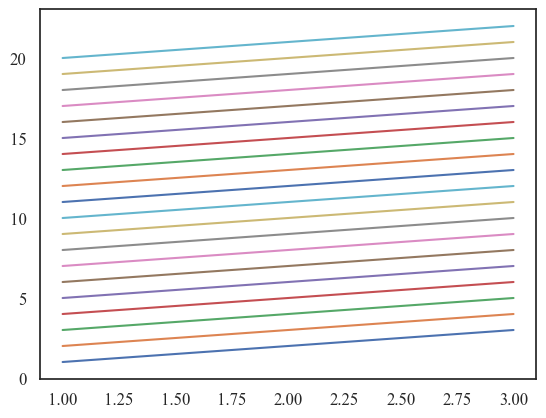

In [33]:
cmap = plt.cm.jet
c1 = [0 / 255, 255 / 255, 0 / 255]
c2 = [255 / 255, 255 / 255, 0 / 255]
c3 = [255 / 255, 0 / 255, 0 / 255]
cmaplist = [c1, c2, c3]
mycmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

cmap = plt.cm.jet
c1 = [0.29803922, 0.44705882, 0.69019608, 0.6]
c2 = [0.86666667, 0.51764706, 0.32156863, 0.6]
cmaplist = [c1, c2]
mycmap11 = cmap.from_list('Custom cmap', cmaplist, cmap.N)

color_col = []
for i in range(20):
    q1 = plt.plot([1,2,3],[1+i,2+i,3+i])
    color_col.append(q1[0].get_color())

cmap = plt.cm.jet
c1 = [0 / 255, 255 / 255, 0 / 255]
c2 = [255 / 255, 255 / 255, 0 / 255]
c3 = [255 / 255, 0 / 255, 0 / 255]
cmaplist = [c1, c2, c3]
mycmap_3type = cmap.from_list('Custom cmap', cmaplist, cmap.N)

In [5]:
def normalization(data):
    # _range = np.max(data) - np.min(data)
    # return (data - np.min(data)) / _range
    return data / np.max(data)

# Model calibration

## data prepare

the raw data is extracted from paper <Which parts of the road guide obstacle avoidance? Quantifying the driver's risk field>

data link: https://data.4tu.nl/articles/dataset/Driver_s_Risk_Fields_DRF_-_Simulator_Experiment/12707702/1

In [6]:
with open('calibration_data.pkl', 'rb') as f:
    objective_data, ObjX, ObjY = pickle.load(f)  # steering angle during experiment, obstacles position

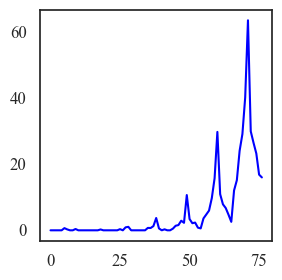

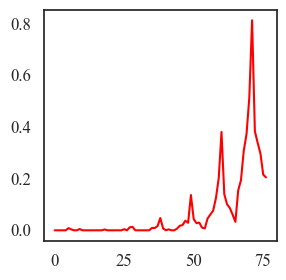

In [7]:
# find the max steering angle values, and normalization
norm_objective_data = []
obj_data_raw = []
max_values = []
use_lines = 25 #25
for subID in range(8):
    objective_data[subID][np.abs(objective_data[subID]) <= 2] = 0
    obj_dataset = []
    for objID in range(77):
        st_angle = np.mean(np.max(np.abs(objective_data[subID][:use_lines,4*objID:4*objID+4]), 0))
        st_angle = 0 if st_angle <2 else st_angle
        obj_dataset.append(st_angle)
    
    tmp = normalization(obj_dataset)

    obj_data_raw.append(copy.deepcopy(obj_dataset))
    norm_objective_data.append(tmp)

    max_values.append(np.max(obj_dataset))


scale_norm_objective_data = []
max_angle = np.array(max_values).max()
scales = np.array(max_values) / max_angle
for i in range(8):
    scale_norm_objective_data.append(np.array(norm_objective_data[i]) * scales[i])

# this is the data after normalization for model calibration
scale_norm_objective_data = np.mean(np.array(scale_norm_objective_data), axis=0)  
# this is the raw average data
obj_data_raw = np.mean(np.array(obj_data_raw), axis=0)  

# print('scale_norm_objective_data:', scale_norm_objective_data)
# print('obj_data_raw:', obj_data_raw)
plt.figure(figsize=(3,3))
plt.plot(obj_data_raw, c='blue')
plt.show()
plt.figure(figsize=(3,3))
plt.plot(scale_norm_objective_data, c='red')

## the best parameter

In [8]:
TTTT = 4

In [9]:
# the best parameters: A=0.4, B=0.25, T=4, has been used in the PODAR model, see 'PODAR.py'
podar_est = []
for objID in range(77):
    x_obj, y_obj = ObjX[objID], ObjY[objID]
    vehicles_1 = PODAR.Vehicles()
    vehicles_1.set_ego(type='car', x0=0, y0=0, speed=25, phi0=0)
    vehicles_1.add_obj(type='car', x0=x_obj, y0=-y_obj, speed=0, phi0=np.pi, length=15, width=0.25)
    podar_risk, _, _ = vehicles_1.estimate_risk()

    podar_est.append(podar_risk)

# calculat R2
label_mean = np.mean(scale_norm_objective_data)
sst = np.power((scale_norm_objective_data - label_mean), 2).sum()
ssr = np.power((np.array(podar_est) * (0.0018 / 0.1) - scale_norm_objective_data), 2).sum()
r2 = 1 - ssr / sst
# here, 0.0018 / 0.1 is because when applying the numercial simuation, to let the podar values in a proper range,
# we do not directly use the 0.0018 scale but using 0.1. We focues on the relatvie size at different moment,
# so this treatment will not influence the proof of feasibility
print('R2 = ', r2)

R2 =  0.8784676491401755


### Figure 5b in paper

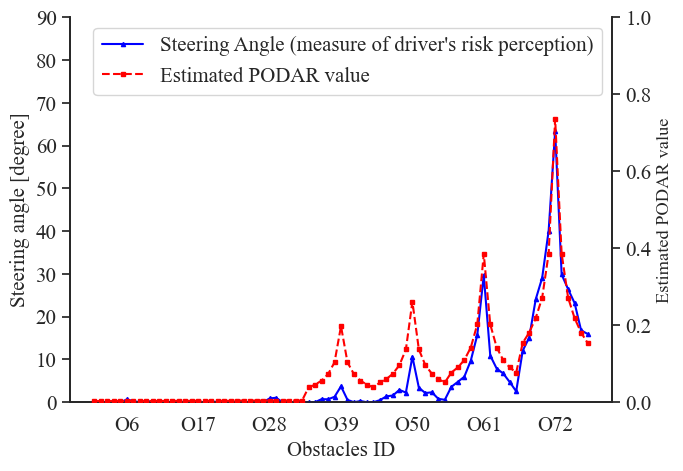

In [10]:
fig = plt.figure(figsize=(7,5))
line1, = plt.plot(np.arange(1, 78, 1), obj_data_raw, label='Steering Angle', zorder=100, marker='^', ms='3', c='blue')
plt.ylabel('Steering angle [degree]', fontsize=15)
_x_ticks_label = ["O{}".format(i) for i in np.arange(6,73, 11)]
plt.xticks(np.arange(6,73, 11), _x_ticks_label, fontsize=15)
plt.ylim([0,90])
plt.xlabel('Obstacles ID', fontsize=15)
plt.yticks(fontsize=15)
plt.gca().spines['top'].set_visible(False)
plt.twinx()
line2, = plt.plot(np.arange(1, 78, 1), np.array(podar_est) * (0.0018 / 0.1), label='PODAR', linestyle='--', zorder=100, marker='s', ms='3', c='red')
plt.ylabel('Estimated PODAR value')
plt.yticks(fontsize=15)
plt.ylim([0,1])

plt.gca().spines['top'].set_visible(False)
plt.legend([line1, line2], ["Steering Angle (measure of driver's risk perception)", 'Estimated PODAR value'], fontsize=15)

# Numerical simuation

## generate data

In [11]:
from numerical_data_generate import generate

In [47]:
# the data will save to 'numerical_data'
generate()

e1 saved
e1 saved


## draw pictures

## Figure 7 - side pass

In [13]:
with open(r'numerical_data\static\vehs.pkl', 'rb') as f:
    vehs, dym_risks, obj_traj_x, obj_traj_y = pickle.load(f)
ego = vehs.ego

sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)

risk_all = np.array([x.risk_curve for x in vehs.obj])
risk_all = risk_all.reshape(155 if TTTT == 3 else 205)
x_all = np.concatenate([np.array(x.x_pred)+offset for (x, offset) in zip(vehs.obj, [0,1.5,3,4.5,6])])
y_all = np.concatenate([x.y_pred for x in vehs.obj])
risk = [x.risk for x in vehs.obj]

dym_risks_2 = np.array(dym_risks)*2
c_norm = colors.Normalize(vmin=dym_risks_2.min(), vmax=dym_risks_2.max(), clip=False)
rcurve_color = mycmap_3type(c_norm(dym_risks_2))

# c_norm_1 = colors.Normalize(vmin=np.array(dym_risks).min(), vmax=np.array(dym_risks).max(), clip=True)
c_norm_1 = colors.Normalize(vmin=0, vmax=np.array(dym_risks).max(), clip=True)

def plot_sta(obj, risk_all, id_, color, risk, offset=0, label=False):
    w, l, h0 = obj.width, obj.length, obj.phi_pred[0]
    rr = np.sqrt(w**2 + l**2) / 2
    betha = atan2(w / 2, l / 2)
    x = obj.x_pred[0] - rr * cos(h0 + betha) + offset
    y = obj.y_pred[0] - rr * sin(h0 + betha)
    if label:
        rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=True, edgecolor='#FFFFFF', facecolor=color, linewidth=2, label='Other Veh.', alpha=0.6)
    else:
        rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=True, edgecolor='#FFFFFF', facecolor=color, linewidth=2, alpha=0.6)
    plt.text(x + 0.5, y, '$PODAR_{' + str(id_) + '}$=' + str(risk),fontsize=13)
    plt.gca().add_patch(rect)

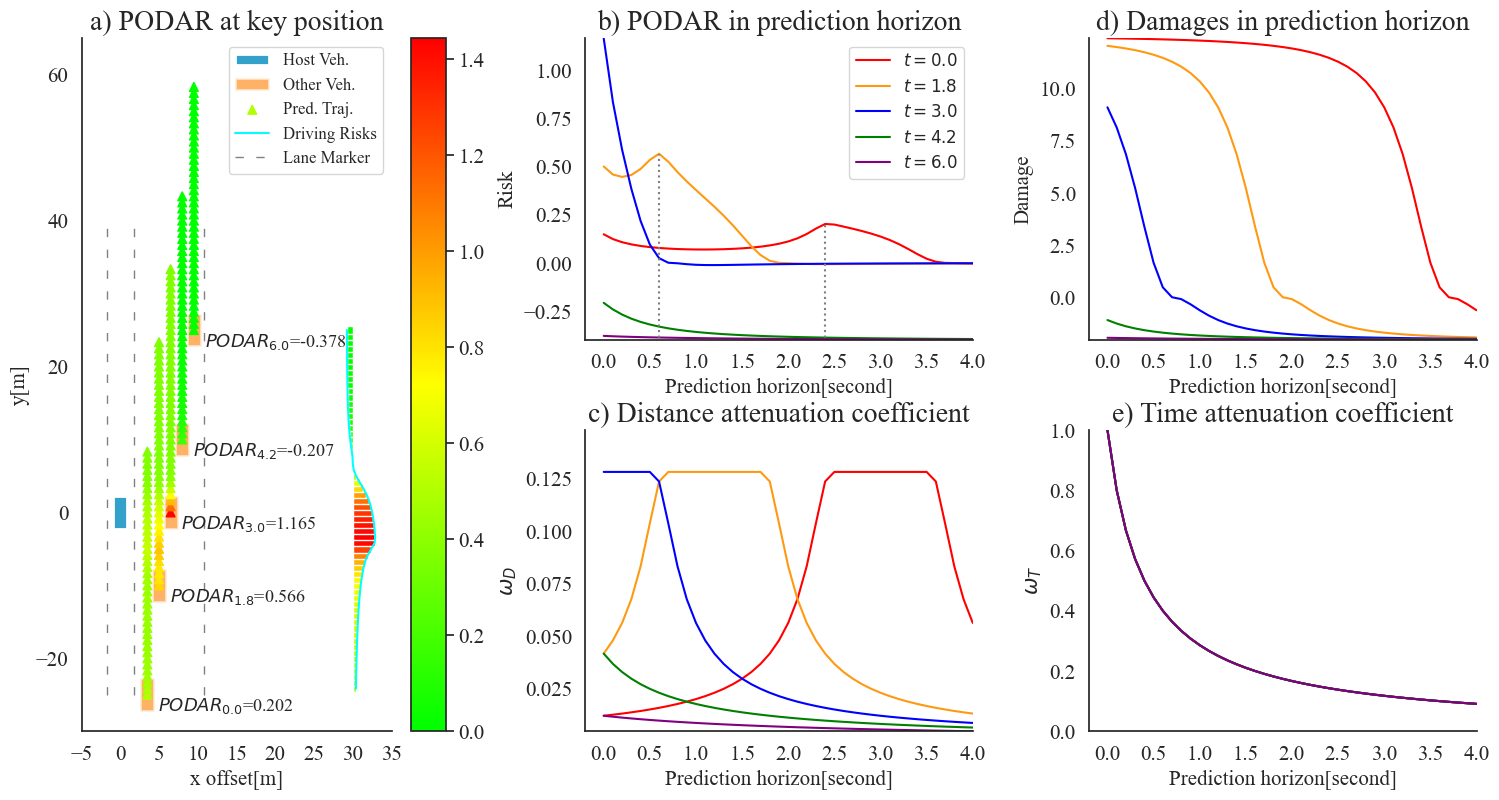

In [14]:
fig = plt.figure(figsize=(18,9))
grid = plt.GridSpec(2,3,wspace=0.3,hspace=0.3, )

ax1 = plt.subplot(grid[:,0])
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)

# ego
obj = ego
w, l, h0 = obj.width, obj.length, obj.phi_pred[0]
rr = np.sqrt(w**2 + l**2) / 2
betha = atan2(w / 2, l / 2)
x = obj.x_pred[0] - rr * cos(h0 + betha)
y = obj.y_pred[0] - rr * sin(h0 + betha)
rect = patches.Rectangle((x, y), l, w, angle=h0 / pi * 180, fill=True, edgecolor='#FFFFFF', facecolor='#33A1C9',linewidth=2, label='Host Veh.')
ax1.add_patch(rect)

plot_sta(vehs.obj[0], risk_all, id_=0.0, color='#FF8000', risk=np.round(risk[0],3), label=True)
plot_sta(vehs.obj[1], risk_all, id_=1.8, color='#FF8000', risk=np.round(risk[1],3), offset=1.5)
plot_sta(vehs.obj[2], risk_all, id_=3.0, color='#FF8000', risk=np.round(risk[2],3), offset=3)
plot_sta(vehs.obj[3], risk_all, id_=4.2, color='#FF8000', risk=np.round(risk[3],3), offset=4.5)
plot_sta(vehs.obj[4], risk_all, id_=6.0, color='#FF8000', risk=np.round(risk[4],3), offset=6)

ax1.scatter(x_all, y_all, s=40, c=risk_all, cmap=mycmap_3type, marker='^', zorder=10, label='Pred. Traj.')

im1 = matplotlib.cm.ScalarMappable(cmap=mycmap_3type, norm=c_norm_1)
cb = fig.colorbar(im1)
# cb.set_label('Risk', fontsize=15)
cb.ax.tick_params(axis="y", labelsize=15)

plt.plot(np.array(dym_risks) *2  + 30, np.array(obj_traj_y), c='#00FFFF', label='Driving Risks')
plt.barh(obj_traj_y,np.array(dym_risks)*2,linewidth=1, height=1, left=[30.], color=rcurve_color)

plt.plot([-1.75, -1.75], [-25, 40], c='gray', linewidth=1, dashes=(6, 9), label='Lane Marker') #linestyle='--',
plt.plot([1.75, 1.75], [-25, 40], c='gray', linewidth=1, dashes=(6, 9)) #linestyle='--',
plt.plot([10.75, 10.75], [-25, 40], c='gray', linewidth=1, dashes=(6, 9)) #linestyle='--',

# plt.axis('equal')
# plt.xticks(fontsize=15)
# ax1.tick_params(axis="x", labelsize=15)
# plt.setp(ax1.get_xticklabels(), fontsize=15, fontweight="bold", horizontalalignment="left")
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xticks(np.linspace(-15,35,11))
plt.xlim((-5, 35))
plt.ylim((-30, 65))
# plt.barh([-25, -10, 0, 10, 25], np.array([x.risk for x in vehs.obj]) * 20, linewidth=2, height=2, left=[3.], label='Overall risk', color=['#FFD700','#FF7D40','#FF8000','#FF7D40','#FFD700'])

plt.legend(loc='upper right')
plt.xlabel('x offset[m]',fontsize=15)
plt.ylabel('y[m]',fontsize=15)
ax1.set_title('a) PODAR at key position',fontsize=20)

ax2 = plt.subplot(grid[0,1])
t = np.linspace(0,3,31) if TTTT == 3 else np.linspace(0,4,41)
ax2lin1 = ax2.plot(t, vehs.obj[0].risk_curve, label='$t=0.0$', c='red')
ax2lin2 = ax2.plot(t, vehs.obj[1].risk_curve, label='$t=1.8$', c='#FF9912')
ax2lin3 = ax2.plot(t, vehs.obj[2].risk_curve, label='$t=3.0$', c='blue')
ax2lin4 = ax2.plot(t, vehs.obj[3].risk_curve, label='$t=4.2$', c='green')
ax2lin5 = ax2.plot(t, vehs.obj[4].risk_curve, label='$t=6.0$', c='purple')
ax2.plot([0.6, 0.6], [-0.9, np.max(vehs.obj[1].risk_curve)], linestyle=':', c='gray')
ax2.plot([2.4, 2.4], [-0.9, np.max(vehs.obj[0].risk_curve)], linestyle=':', c='gray')

ax2.legend(loc='upper right')
ax2.set_title('b) PODAR in prediction horizon',fontsize=20)
ax2.tick_params(axis="x", labelsize=15)
ax2.tick_params(axis="y", labelsize=15)
ax2.set_xlabel('Prediction horizon[second]', fontsize=15)
ax2.set_ylabel('Risk', fontsize=15)
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.set_xlim([-0.2,TTTT])
ax2.set_ylim([np.min([x.risk_curve for x in vehs.obj]),np.max([x.risk_curve for x in vehs.obj])])
ax2.set_xticks(np.linspace(0, TTTT, TTTT * 2 +1))

ax3 = plt.subplot(grid[1,1])
ax3.plot(t, vehs.obj[0].dis_de_curve, label='$t=0.0$', c='red')
ax3.plot(t, vehs.obj[1].dis_de_curve, label='$t=1.8$', c='#FF9912')
ax3.plot(t, vehs.obj[2].dis_de_curve, label='$t=3.0$', c='blue')
ax3.plot(t, vehs.obj[3].dis_de_curve, label='$t=4.2$', c='green')
ax3.plot(t, vehs.obj[4].dis_de_curve, label='$t=6.0$', c='purple')
# ax3.legend(loc='upper right')
ax3.set_title('c) Distance attenuation coefficient',fontsize=20)
ax3.tick_params(axis="x", labelsize=15)
ax3.tick_params(axis="y", labelsize=15)
ax3.set_xlabel('Prediction horizon[second]', fontsize=15)
ax3.set_ylabel('$\omega_D$', fontsize=15)
ax3.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.set_xlim([-0.2,TTTT])
ax3.set_ylim([np.min([x.dis_de_curve for x in vehs.obj]),np.max([x.dis_de_curve for x in vehs.obj])+0.02])
ax3.set_xticks(np.linspace(0, TTTT, TTTT * 2 +1))

ax4 = plt.subplot(grid[0,2])
ax4.plot(t, vehs.obj[0].damage, label='$t=0.0$', c='red')
ax4.plot(t, vehs.obj[1].damage, label='$t=1.8$', c='#FF9912')
ax4.plot(t, vehs.obj[2].damage, label='$t=3.0$', c='blue')
ax4.plot(t, vehs.obj[3].damage, label='$t=4.2$', c='green')
ax4.plot(t, vehs.obj[4].damage, label='$t=6.0$', c='purple')
# ax4.legend()
ax4.set_title('d) Damages in prediction horizon',fontsize=20)
ax4.tick_params(axis="x", labelsize=15)
ax4.tick_params(axis="y", labelsize=15)
ax4.set_xlabel('Prediction horizon[second]', fontsize=15)
ax4.set_ylabel('Damage', fontsize=15)
ax4.spines['right'].set_visible(False)
ax4.spines['top'].set_visible(False)
ax4.set_xlim([-0.2,TTTT])
ax4.set_ylim([np.min([x.damage for x in vehs.obj]),np.max([x.damage for x in vehs.obj])])
ax4.set_xticks(np.linspace(0, TTTT, TTTT * 2 +1))

ax5 = plt.subplot(grid[1,2])
ax5.plot(t, vehs.obj[0].weight_t, label='$t=0.0$', c='red')
ax5.plot(t, vehs.obj[1].weight_t, label='$t=1.8$', c='#FF9912')
ax5.plot(t, vehs.obj[2].weight_t, label='$t=3.0$', c='blue')
ax5.plot(t, vehs.obj[3].weight_t, label='$t=4.2$', c='green')
ax5.plot(t, vehs.obj[4].weight_t, label='$t=6.0$', c='purple')
# ax5.legend()
ax5.set_title('e) Time attenuation coefficient',fontsize=20)
ax5.tick_params(axis="x", labelsize=15)
ax5.tick_params(axis="y", labelsize=15)
ax5.set_xlabel('Prediction horizon[second]', fontsize=15)
ax5.set_ylabel('$\omega_T$', fontsize=15)
ax5.spines['right'].set_visible(False)
ax5.spines['top'].set_visible(False)
ax5.set_xlim([-0.2,TTTT])
ax5.set_ylim([0,1.0])
ax5.set_xticks(np.linspace(0, TTTT, TTTT * 2 +1))


## Figure 8 - car-following snap-shot

In [15]:
with open(r'numerical_data\car_following\vehs1.pkl', 'rb') as f:
    vehs = pickle.load(f)
ego = vehs.ego

In [16]:
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.1)

(-20.0, 20.0)

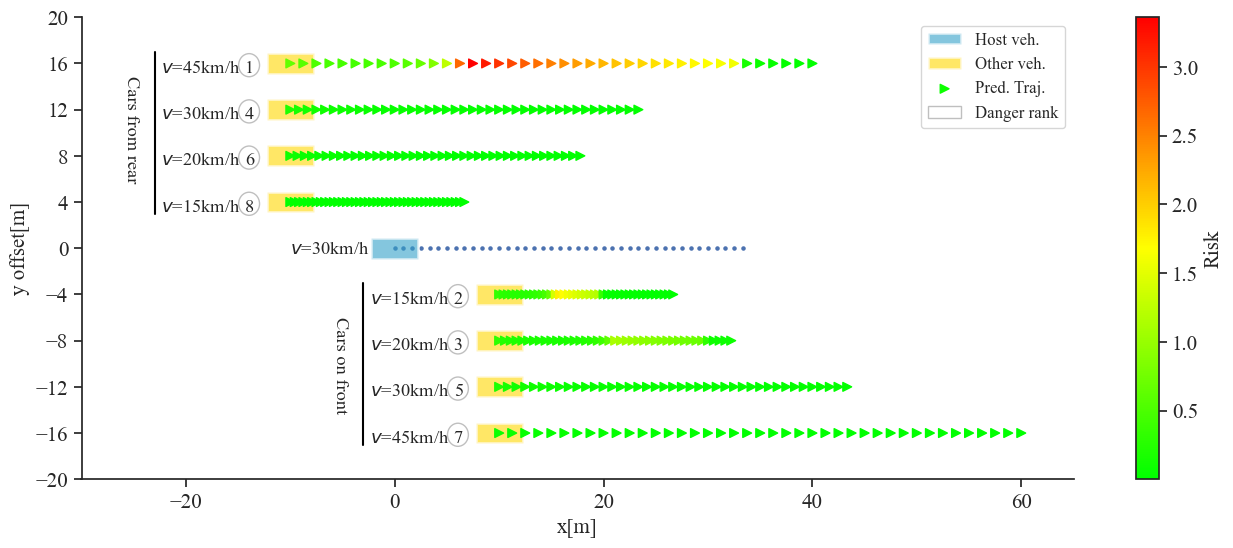

In [17]:
risk_all = np.array([x.risk_curve for x in vehs.obj])
vmin = risk_all.min()
vmax = risk_all.max()
norm = colors.Normalize(vmin=vmin, vmax=vmax)
risk1 = np.array([x.risk for x in vehs.obj])
collided = np.array([x.collided for x in vehs.obj])

fig = plt.figure(figsize=(16,6))
grid = plt.GridSpec(1,1,wspace=0.3,hspace=0.3, )
ax1 = plt.subplot(grid[0,0])

# ego
rect = patches.Rectangle((ego.rect_x, ego.rect_y), ego.length, ego.width, angle=ego.rect_phi, 
                          fill=True, edgecolor='#FFFFFF', facecolor='#33A1C9', linewidth=2, label='Host veh.', alpha=0.6)
ax1.scatter(ego.x_pred, ego.y_pred, s=20, color=color_col[0], marker='.')
ax1.add_patch(rect)
ax1.text(-10, -0.5, '$v$=' + str(30) + 'km/h')

#obj
offset, i, dengerous_level = [-16, -12, -8, -4, 4, 8, 12, 16, 4], 0,  np.abs(np.argsort(np.argsort(risk1))-7)
speed_ = [45, 30, 20, 15, 15, 20, 30, 45]
for _obj in vehs.obj:
    rect = patches.Rectangle((_obj.rect_x, _obj.rect_y + offset[i]), _obj.length, _obj.width, angle=_obj.rect_phi, 
                          fill=True, edgecolor='#FFFFFF', facecolor='#FFD700', linewidth=2, label='Other veh.', alpha=0.6)
    ax1.add_patch(rect)
    ax1.scatter(np.array(_obj.x_pred), np.array(_obj.y_pred) + offset[i], s=40, c=_obj.risk_curve, norm=norm, cmap=mycmap, marker='>', label='Pred. Traj.')
    
    cir1 = Circle(xy = (_obj.rect_x - 1.7, _obj.rect_y  + offset[i] + 0.75), radius=1, alpha=0.5, fc='white', color='gray', fill=True, label='Danger rank')
    ax1.add_patch(cir1)
    
    ax1.text(_obj.rect_x - 2.1, _obj.rect_y + offset[i] + 0.1, str(dengerous_level[i] + 1))
    
    ax1.text(_obj.rect_x - 2.1 - 8, _obj.rect_y + offset[i] + 0.1, '$v$=' + str(speed_[i]) + 'km/h')
    
    i += 1

im1 = matplotlib.cm.ScalarMappable(cmap=mycmap, norm=norm)
cb = fig.colorbar(im1)
cb.set_label('Risk', fontsize=15)
cb.ax.tick_params(axis="y", labelsize=15)

# cb=plt.colorbar()
# cb.ax.tick_params(labelsize=15)  #设置色标刻度字体大小。
ax1.set_yticks([-20, -16, -12, -8, -4, 0, 4, 8, 12, 16, 20])
ax1.tick_params(axis="x", labelsize=15)
ax1.tick_params(axis="y", labelsize=15)



handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:3] + [handles[-1]], labels[:3] + [labels[-1]])
# ax1.legend()
ax1.set_xlabel('x[m]',fontsize=15)
ax1.set_ylabel('y offset[m]',fontsize=15)

ax1.plot([-3,-3], [-17, -3], c='black')
ax1.text(-6, -14, 'Cars on front', ha='left', rotation=270)
ax1.plot([-23,-23], [17, 3], c='black')
ax1.text(-26, 6, 'Cars from rear', ha='left', rotation=270)

# plt.axis('equal')

ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax1.set_xlim([-30,65])
ax1.set_ylim([-20,20])


## Figure 9 - conflict

### 9a - host vehicle is stationary

In [29]:
with open(r'numerical_data\0.0kmph\results.pkl', 'rb') as f:
    data = pickle.load(f)
data.rename(columns={'x':'raw_x', 'y':'raw_y', 'risk': 'Risk', 'type': 'Type'}, inplace=True)
data['phi_de'] = np.round(data['phi_de'])
data['ov_speed_km'] = np.round(data['ov_speed_km'])
data['r'] = np.round(data['r'])

with open(r'numerical_data\0.0kmph\vehs.pkl', 'rb') as f:
    vehs = pickle.load(f)
ego = vehs.ego

In [30]:
use_data = data[(data['Type']=='car') & (data['ov_speed_km']!=10)]
use_data['Sur. Veh. V'] = use_data['ov_speed_km'].apply(lambda _: str(_) + 'km/h')
# use_data.reset_index(inplace=True)

v1, v2 = 30, 45
use_data['x'], use_data['y'] = 0, 0
use_data['x'][use_data['ov_speed_km']==v1] = use_data['raw_x'] + 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v1] = use_data['raw_y'] + 1.2 * np.sin(use_data['phi'])
use_data['x'][use_data['ov_speed_km']==v2] = use_data['raw_x'] - 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v2] = use_data['raw_y'] - 1.2 * np.sin(use_data['phi'])

use_data.head(1)

,ego_speed,r,Type,phi,phi_de,raw_x,raw_y,ov_speed,ov_speed_km,Risk,risk_curve,collided,rc,Sur. Veh. V,x,y
1,0.0,15.0,car,-3.141593,-180.0,15.0,0.0,8.333333,30.0,2.288872,"[0.25523614497708885, 0.21902542526513238, 0.1...",1,0,30.0km/h,13.8,-1.469576e-16


In [31]:
sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)

(-39.82, 39.82, -38.56, 39.760000000000005)

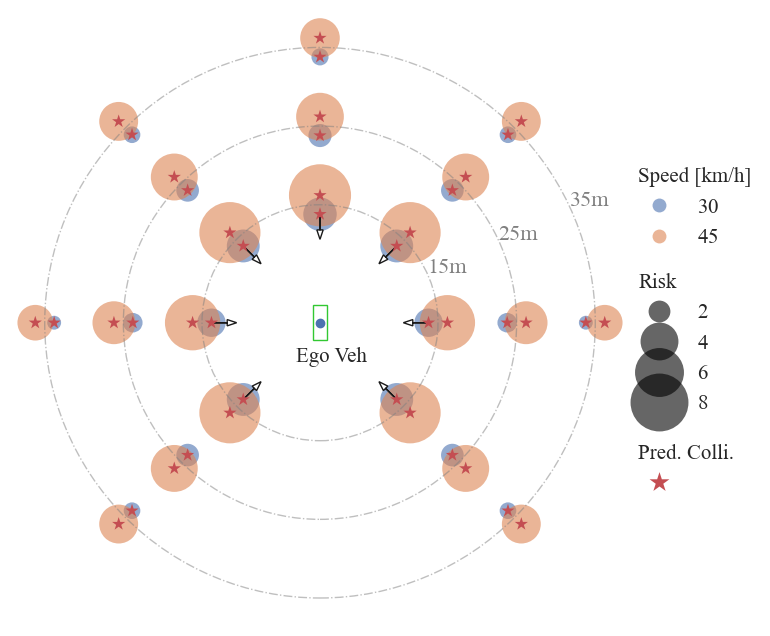

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

max_risk = use_data['Risk'].max()
min_risk = use_data['Risk'].min()
scale_cof_max = 2000.
scale_cof_min = 100.  # scale_cof_max / max_risk * min_risk

size_plot = (use_data['Risk'] - min_risk) / (max_risk - min_risk) * (scale_cof_max - scale_cof_min) + scale_cof_min
sc = ax.scatter(use_data['x'], use_data['y'], s=size_plot, c=use_data['ov_speed_km'], alpha=0.6,
                edgecolor="none", linewidth=0, cmap=mycmap11) # vmin=30, vmax=45,

col_legend = ax.legend(*sc.legend_elements(), loc=(1, 0.6), title="Speed [km/h]", frameon=False, fontsize=15, title_fontsize=15)
col_legend._legend_box.align = "left"
col_legend.legendHandles[0].set_markersize(10)
col_legend.legendHandles[1].set_markersize(10)
ax.add_artist(col_legend)

kw1 = dict(prop="sizes", num=5, color='black', func=lambda s: (s - min_risk) / (scale_cof_max - scale_cof_min) * (max_risk - min_risk) + min_risk, linewidth=0) #  alpha=1
size_legend = ax.legend(*sc.legend_elements(**kw1), loc=(1, 0.33), title="Risk", frameon=False, fontsize=15, title_fontsize=15)
size_legend._legend_box.align = "left"
ax.add_artist(size_legend)

cir1 = Circle(xy = (0.0, 0.0), radius=15, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir2 = Circle(xy = (0.0, 0.0), radius=25, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir3 = Circle(xy = (0.0, 0.0), radius=35, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(15*cos(25/180*pi), 15*sin(25/180*pi), '15m',c='gray', fontsize=16)
ax.text(25*cos(25/180*pi), 25*sin(25/180*pi), '25m',c='gray', fontsize=16)
ax.text(35*cos(25/180*pi), 35*sin(25/180*pi), '35m',c='gray', fontsize=16)

viz_0(ego, ax, ego_flag=1)

for index, row in use_data.iterrows():
    if row['r'] == 15 and row['ov_speed_km'] == 30:
        c = 'k' # 'r' if row['collided'] == 60 / 3.6 else 'k'
        plt.arrow(row['x'], row['y'], np.cos(row['phi']) * 2, np.sin(row['phi']) * 2, width=0.003, head_width=0.8,
                  fc='white', ec=c)

from matplotlib.colors import ListedColormap
colours = ListedColormap(['r'])
collision_data = use_data[use_data['collided']==1]
sc_colli = ax.scatter(collision_data['x'], collision_data['y'], marker='*', c=[0] * collision_data.shape[0], s=100, alpha=1, linewidth=0, label='co', cmap=colours)

colli_legend = ax.legend(*sc_colli.legend_elements(), loc=(1, 0.2), title="Pred. Colli.", frameon=False, fontsize=15, title_fontsize=15)
colli_legend._legend_box.align = "left"
colli_legend.get_texts()[0].set_text('')  # or # colli_legend.get_texts()[0].set_color('white')
colli_legend.legendHandles[0].set_markersize(15)


plt.axis('equal')


### 9b - host vehicle is moving

In [35]:
with open(r'numerical_data\30.0kmph\results.pkl', 'rb') as f:
    data = pickle.load(f)
data.rename(columns={'x':'raw_x', 'y':'raw_y', 'risk': 'Risk', 'type': 'Type'}, inplace=True)
data['phi_de'] = np.round(data['phi_de'])
data['ov_speed_km'] = np.round(data['ov_speed_km'])
data['r'] = np.round(data['r'])

with open(r'numerical_data\30.0kmph\vehs.pkl', 'rb') as f:
    vehs = pickle.load(f)
ego = vehs.ego

In [36]:
sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)
use_data = data[(data['Type']=='car') & (data['ov_speed_km']!=10)]
use_data['Sur. Veh. V'] = use_data['ov_speed_km'].apply(lambda _: str(_) + 'km/h')
# use_data.reset_index(inplace=True)

v1, v2 = 30, 45
use_data['x'], use_data['y'] = 0, 0
use_data['x'][use_data['ov_speed_km']==v1] = use_data['raw_x'] + 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v1] = use_data['raw_y'] + 1.2 * np.sin(use_data['phi'])
use_data['x'][use_data['ov_speed_km']==v2] = use_data['raw_x'] - 1.2 * np.cos(use_data['phi'])
use_data['y'][use_data['ov_speed_km']==v2] = use_data['raw_y'] - 1.2 * np.sin(use_data['phi'])

use_data.head(1)

,ego_speed,r,Type,phi,phi_de,raw_x,raw_y,ov_speed,ov_speed_km,Risk,risk_curve,collided,rc,Sur. Veh. V,x,y
1,8.333333,15.0,car,-3.141593,-180.0,15.0,0.0,8.333333,30.0,0.31101,"[0.31101036972399443, 0.2602407452826015, 0.22...",0,0,30.0km/h,13.8,-1.469576e-16


(-39.82, 39.82, -38.56, 39.760000000000005)

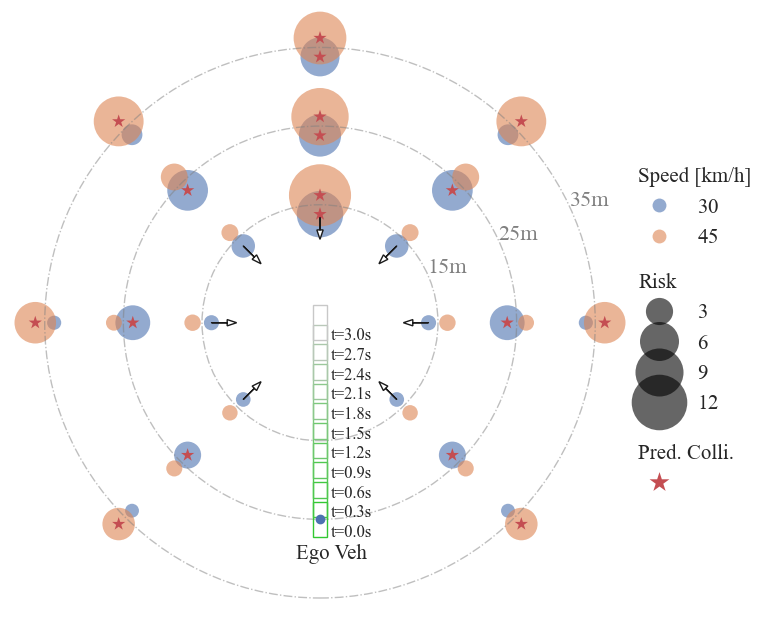

In [37]:
fig = plt.figure(figsize=(8, 8))
# grid = plt.GridSpec(2,3,wspace=0.3,hspace=0.3, )
# ax = plt.subplot(grid[:,:2])
ax = fig.add_subplot()

max_risk = use_data['Risk'].max()
min_risk = use_data['Risk'].min()
scale_cof_max = 2000.
scale_cof_min = 100.  # scale_cof_max / max_risk * min_risk

size_plot = (use_data['Risk'] - min_risk) / (max_risk - min_risk) * (scale_cof_max - scale_cof_min) + scale_cof_min
sc = ax.scatter(use_data['x'], use_data['y'], s=size_plot, c=use_data['ov_speed_km'], alpha=0.6,
                edgecolor="none", linewidth=0, cmap=mycmap11) # vmin=30, vmax=45,

col_legend = ax.legend(*sc.legend_elements(), loc=(1, 0.6), title="Speed [km/h]", frameon=False, fontsize=15, title_fontsize=15)
col_legend._legend_box.align = "left"
# col_legend.legendHandles[0]._legmarker.set_markersize(10)
# col_legend.legendHandles[1]._legmarker.set_markersize(10)
col_legend.legendHandles[0].set_markersize(10)
col_legend.legendHandles[1].set_markersize(10)
ax.add_artist(col_legend)

kw1 = dict(prop="sizes", num=5, color='black', func=lambda s: (s - min_risk) / (scale_cof_max - scale_cof_min) * (max_risk - min_risk) + min_risk, linewidth=0) #  alpha=1
size_legend = ax.legend(*sc.legend_elements(**kw1), loc=(1, 0.33), title="Risk", frameon=False, fontsize=15, title_fontsize=15)
size_legend._legend_box.align = "left"
ax.add_artist(size_legend)

cir1 = Circle(xy = (0.0, 0.0), radius=15, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir2 = Circle(xy = (0.0, 0.0), radius=25, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir3 = Circle(xy = (0.0, 0.0), radius=35, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(15*cos(25/180*pi), 15*sin(25/180*pi), '15m',c='gray', fontsize=16)
ax.text(25*cos(25/180*pi), 25*sin(25/180*pi), '25m',c='gray', fontsize=16)
ax.text(35*cos(25/180*pi), 35*sin(25/180*pi), '35m',c='gray', fontsize=16)

viz(ego, ax, ego_flag=1)

for index, row in use_data.iterrows():
    if row['r'] == 15 and row['ov_speed_km'] == 30:
        c = 'k' # 'r' if row['collided'] == 60 / 3.6 else 'k'
        plt.arrow(row['x'], row['y'], np.cos(row['phi']) * 2, np.sin(row['phi']) * 2, width=0.003, head_width=0.8,
                  fc='white', ec=c)
    # if row['collided'] == 1:
    #     sc = plt.scatter(row['x'], row['y'], marker='*', c='red', s=100, alpha=0.5, linewidth=0)

from matplotlib.colors import ListedColormap
colours = ListedColormap(['r'])
collision_data = use_data[use_data['collided']==1]
sc_colli = ax.scatter(collision_data['x'], collision_data['y'], marker='*', c=[0] * collision_data.shape[0], s=100, alpha=1, linewidth=0, label='co', cmap=colours)

colli_legend = ax.legend(*sc_colli.legend_elements(), loc=(1, 0.2), title="Pred. Colli.", frameon=False, fontsize=15, title_fontsize=15)
colli_legend._legend_box.align = "left"
colli_legend.get_texts()[0].set_text('')  # or # colli_legend.get_texts()[0].set_color('white')
# colli_legend.legendHandles[0]._legmarker.set_markersize(15)
colli_legend.legendHandles[0].set_markersize(15)
# ax.add_artist(colli_legend)

# plt.gca().legend((sc,),('',), frameon=False, loc=(1.05,0.26))
# plt.text(1.085,0.3, 'Pred. Colli.', transform=plt.gca().transAxes) #horizontalalignment='center',verticalalignment='center', 


plt.axis('equal')


### 9c - predicted risks

In [ ]:
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.1)

In [38]:
tmp_data = data[(data['Type']=='car') & (data['ov_speed_km']!=10) & (data['phi_de']==-180.)]
tmp_data

,ego_speed,r,Type,phi,phi_de,raw_x,raw_y,ov_speed,ov_speed_km,Risk,risk_curve,collided,rc
1,8.333333,15.0,car,-3.141593,-180.0,15.0,0.0,8.333333,30.0,0.311010,"[0.31101036972399443, 0.2602407452826015, 0.22...",0,0
2,8.333333,15.0,car,-3.141593,-180.0,15.0,0.0,12.500000,45.0,0.469513,"[0.4695127435942217, 0.3932812200772402, 0.343...",0,0
64,8.333333,25.0,car,-3.141593,-180.0,25.0,0.0,8.333333,30.0,4.077314,"[0.2536007841038738, 0.21085795975157914, 0.18...",1,0
65,8.333333,25.0,car,-3.141593,-180.0,25.0,0.0,12.500000,45.0,0.403141,"[0.40314063018186236, 0.338282633395223, 0.296...",0,0
127,8.333333,35.0,car,-3.141593,-180.0,35.0,0.0,8.333333,30.0,0.200237,"[0.20023700166569425, 0.16497877162625, 0.1417...",0,0
128,8.333333,35.0,car,-3.141593,-180.0,35.0,0.0,12.500000,45.0,6.047790,"[0.32507794253442523, 0.2704961174877465, 0.23...",1,0


In [39]:
use_data = data[(data['Type']=='car') & (data['ov_speed_km']!=10) & (data['phi_de']==-180.)]
use_data_s30r15 = use_data['risk_curve'][1]
use_data_s45r15 = use_data['risk_curve'][2]
use_data_s30r25 = use_data['risk_curve'][64]
use_data_s45r25 = use_data['risk_curve'][65]
use_data_s30r35 = use_data['risk_curve'][127]
use_data_s45r35 = use_data['risk_curve'][128]
t = np.linspace(0, TTTT, TTTT * 10 +1)

(0.0, 7.0)

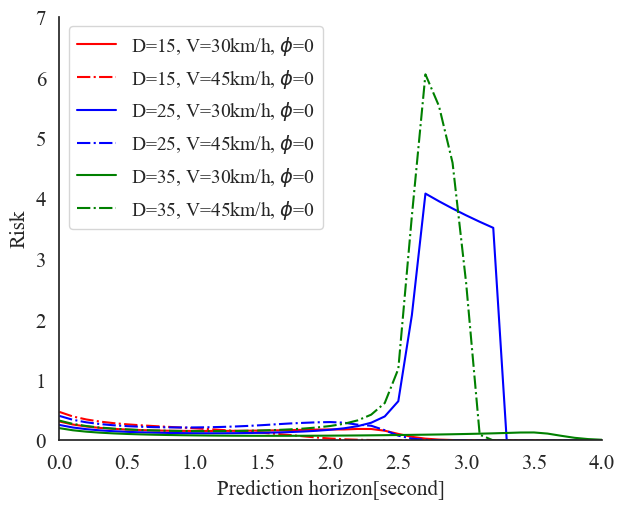

In [40]:
fig = plt.figure(figsize=(7,5.5))
ax = fig.add_subplot()
line0 = ax.plot(t, use_data_s30r15, label='D=15, V=30km/h, $\phi$=0', linestyle='-', c='red')  # c=(76/255,114/255,176/255), 
line1 = ax.plot(t, use_data_s45r15, label='D=15, V=45km/h, $\phi$=0', linestyle='-.', c='red')  # c=(221/255,132/255,82/255), 
line2 = ax.plot(t, use_data_s30r25, label='D=25, V=30km/h, $\phi$=0', linestyle='-', c='blue')  # c=(76/255,114/255,176/255), 
line3 = ax.plot(t, use_data_s45r25, label='D=25, V=45km/h, $\phi$=0', linestyle='-.', c='blue')  # c=(221/255,132/255,82/255), 
line4 = ax.plot(t, use_data_s30r35, label='D=35, V=30km/h, $\phi$=0', linestyle='-', c='green')  # c=(76/255,114/255,176/255), 
line5 = ax.plot(t, use_data_s45r35, label='D=35, V=45km/h, $\phi$=0', linestyle='-.', c='green')  # c=(221/255,132/255,82/255), 
ax.legend(fontsize=14)
# ax.set_title('Risk curve during prediction horizon',fontsize=20)
ax.tick_params(axis="x", labelsize=15)
ax.tick_params(axis="y", labelsize=15)
ax.set_xlabel('Prediction horizon[second]', fontsize=15)
ax.set_ylabel('Risk', fontsize=15)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,TTTT])
plt.ylim([0,7])

# plt.savefig(r'f:\inkscape_output\30vs45_risk_curve.svg', bbox_inches='tight', pad_inches=0 )  # transparent = True,
# plt.savefig(r'e:\博后工作资料\01_研究工作\06_论文\02_PCD模型\202302_ID01_PODAR add exp_Revise\images\fig10_1_30vs45_curve.pdf', bbox_inches='tight', pad_inches=0)

### 9d - different types

In [41]:
# with car 30km/h
use_data1 = data[(data['ov_speed_km']==10)] # & (data['phi']<=0)]
use_data2 = data[(data['Type']=='car') & (data['ov_speed_km']==30)] # & (data['phi']<=0)]
use_data = pd.concat((use_data1, use_data2))

# use_data.reset_index(inplace=True)
print(data.shape, use_data.shape)
type1, type2 = 'car', 'bic'
v0, v1 = 10, 30
use_data['x'], use_data['y'] = 0, 0
use_data['x'][use_data['Type']==type1] = use_data['raw_x'] # + 1 * np.cos(use_data['phi'])
use_data['y'][use_data['Type']==type1] = use_data['raw_y'] # + 1 * np.sin(use_data['phi'])
use_data['x'][use_data['Type']==type2] = use_data['raw_x'] - 1.8 * np.cos(use_data['phi'])
use_data['y'][use_data['Type']==type2] = use_data['raw_y'] - 1.8 * np.sin(use_data['phi'])
use_data['x'][(use_data['Type']=='car') & (use_data['ov_speed_km']==v1)] = use_data['raw_x'] + 1.8 * np.cos(use_data['phi'])
use_data['y'][(use_data['Type']=='car') & (use_data['ov_speed_km']==v1)] = use_data['raw_y'] + 1.8 * np.sin(use_data['phi'])

# use_data['Type-Speed'] = use_data['Type'].str.cat(use_data['ov_speed_km'].apply(lambda x: str(x) + 'km/h'), sep='-')
use_data['color'] = None
use_data['color'][(use_data['Type']==type2) & (use_data['ov_speed_km']==v0)] = 0
use_data['color'][(use_data['Type']==type1) & (use_data['ov_speed_km']==v0)] = 1
use_data['color'][(use_data['Type']==type1) & (use_data['ov_speed_km']==v1)] = 2

print(use_data['color'].unique())

(189, 13) (63, 13)
[1 0 2]


In [42]:
sns.set_theme(style="white",font='Times New Roman',font_scale=1.1)
c1 = [0.29803922, 0.44705882, 0.69019608, 0.6]
c2 = [0.33333333, 0.65882352, 0.40784313, 0.6]
c3 = [0.86666667, 0.51764706, 0.32156863, 0.6]
cmaplist = [c1, c2, c3]
mycmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

(-40.48, 40.48, -38.59, 40.39)

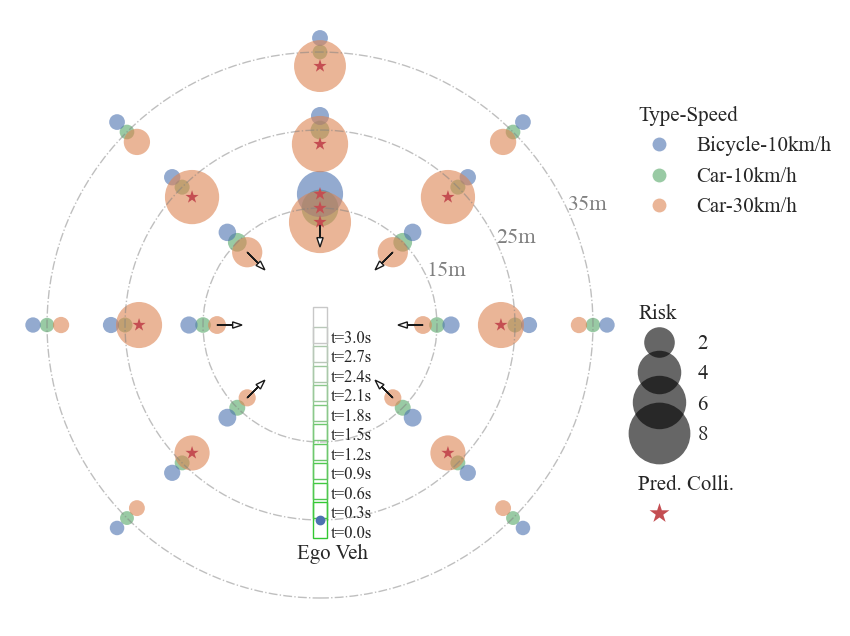

In [44]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot()

max_risk = use_data['Risk'].max()
min_risk = use_data['Risk'].min()
scale_cof_max = 2000.
scale_cof_min = 100.  # scale_cof_max / max_risk * min_risk

size_plot = (use_data['Risk'] - min_risk) / (max_risk - min_risk) * (scale_cof_max - scale_cof_min) + scale_cof_min
sc = ax.scatter(use_data['x'], use_data['y'], s=size_plot, c=use_data['color'], alpha=0.6,
                edgecolor="none", linewidth=0, cmap=mycmap) # vmin=30, vmax=45,

col_legend = ax.legend(*sc.legend_elements(), loc=(1, 0.65), title="Type-Speed", frameon=False, fontsize=15, title_fontsize=15)
col_legend._legend_box.align = "left"
# col_legend.legendHandles[0]._legmarker.set_markersize(10)
# col_legend.legendHandles[1]._legmarker.set_markersize(10)
# col_legend.legendHandles[2]._legmarker.set_markersize(10)
col_legend.legendHandles[0].set_markersize(10)
col_legend.legendHandles[1].set_markersize(10)
col_legend.legendHandles[2].set_markersize(10)
col_legend.get_texts()[0].set_text('Bicycle-10km/h')
col_legend.get_texts()[1].set_text('Car-10km/h')
col_legend.get_texts()[2].set_text('Car-30km/h')
ax.add_artist(col_legend)

kw1 = dict(prop="sizes", num=5, color='black', func=lambda s: (s - min_risk) / (scale_cof_max - scale_cof_min) * (max_risk - min_risk) + min_risk, linewidth=0) #  alpha=1
size_legend = ax.legend(*sc.legend_elements(**kw1), loc=(1, 0.28), title="Risk", frameon=False, fontsize=15, title_fontsize=15)
size_legend._legend_box.align = "left"
ax.add_artist(size_legend)

cir1 = Circle(xy = (0.0, 0.0), radius=15, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir2 = Circle(xy = (0.0, 0.0), radius=25, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
cir3 = Circle(xy = (0.0, 0.0), radius=35, alpha=0.5, ls='-.', fc=None, color='gray', fill=False)
ax.add_patch(cir1)
ax.add_patch(cir2)
ax.add_patch(cir3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.text(15*cos(25/180*pi), 15*sin(25/180*pi), '15m',c='gray', fontsize=16)
ax.text(25*cos(25/180*pi), 25*sin(25/180*pi), '25m',c='gray', fontsize=16)
ax.text(35*cos(25/180*pi), 35*sin(25/180*pi), '35m',c='gray', fontsize=16)

viz(ego, ax, ego_flag=1)

for index, row in use_data.iterrows():
    if row['r'] == 15 and row['ov_speed_km'] == 30 and row['Type'] == 'car':
        c = 'k' # 'r' if row['collided'] == 60 / 3.6 else 'k'
        ax.arrow(row['x'], row['y'], np.cos(row['phi']) * 2, np.sin(row['phi']) * 2, width=0.003, head_width=0.8,
                  fc='white', ec=c)
    # if row['collided'] == 1:
    #     sc = plt.scatter(row['x'], row['y'], marker='*', c='red', s=100, alpha=0.5, linewidth=0)

from matplotlib.colors import ListedColormap
colours = ListedColormap(['r'])
collision_data = use_data[use_data['collided']==1]
sc_colli = ax.scatter(collision_data['x'], collision_data['y'], marker='*', c=[0] * collision_data.shape[0], s=100, alpha=1, linewidth=0, label='co', cmap=colours)

colli_legend = ax.legend(*sc_colli.legend_elements(), loc=(1, 0.15), title="Pred. Colli.", frameon=False, fontsize=15, title_fontsize=15)
colli_legend._legend_box.align = "left"
colli_legend.get_texts()[0].set_text('')  # or # colli_legend.get_texts()[0].set_color('white')
colli_legend.legendHandles[0].set_markersize(15)
colli_legend.legendHandles[0].set_markersize(15)
# ax.add_artist(colli_legend)

# plt.gca().legend((sc,),('',), frameon=False, loc=(1.05,0.26))
# plt.text(1.085,0.3, 'Pred. Colli.', transform=plt.gca().transAxes) #horizontalalignment='center',verticalalignment='center', 


plt.axis('equal')

## Figure 11 - comparison

In [48]:
with open(r'numerical_data\car_following\vehs_dynamic_collision_free.pkl', 'rb') as f:
    risks, x1, x2, v, d, ttc, drac, sf, a, drf, media_var, _ = pickle.load(f)

with open(r'numerical_data\car_following\vehs_dynamic_collision.pkl', 'rb') as f:
    risks_c, x1_c, x2_c, v_c, d_c, ttc_c, drac_c, sf_c, a_c, drf_c, media_var_c, collided_c = pickle.load(f)

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

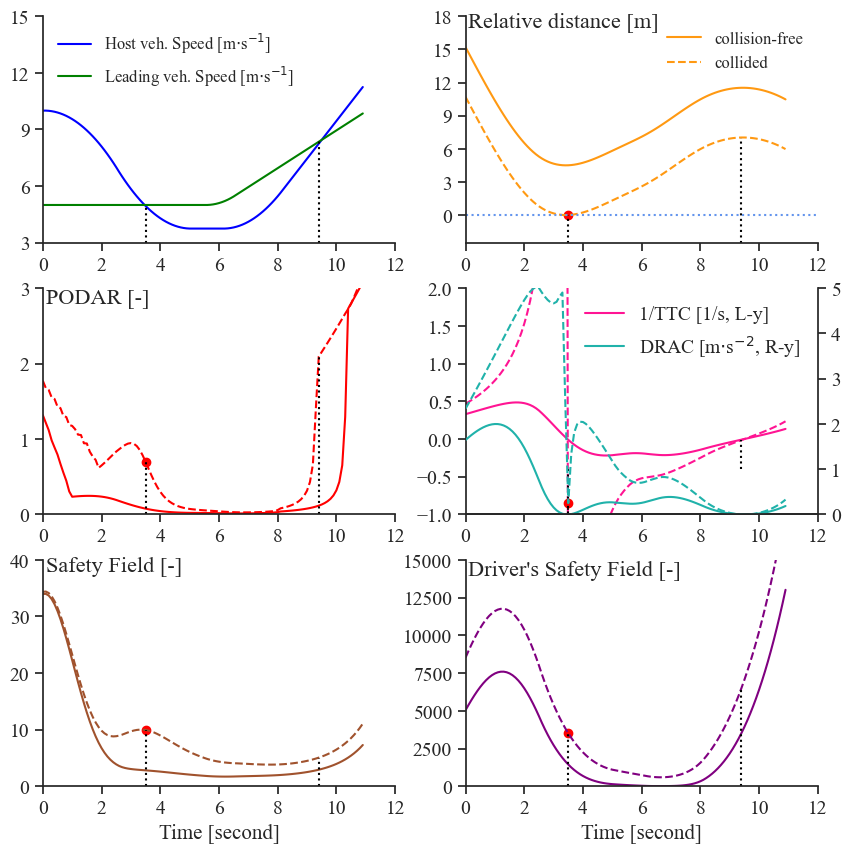

In [50]:
sns.set_theme(style="ticks",font='Times New Roman',font_scale=1.1)


fig = plt.figure(figsize=(10,10))
grid = plt.GridSpec(3,2,wspace=0.2,hspace=0.2)
ti = 11

zero_rv_min = np.where(np.array(v[0])<0)[0].min() / 10
zero_rv_max = np.where(np.array(v[0])<0)[0].max() / 10

plt.subplot(grid[0,0])
plt.plot(np.arange(0, ti, 0.1), v[1], label='Host veh. Speed [m$\cdot$s$^{-1}$]', c='blue')
plt.plot(np.arange(0, ti, 0.1), v[2], label='Leading veh. Speed [m$\cdot$s$^{-1}$]', c='green')
# plt.ylabel('Speed [m$\cdot$s]')
# plt.plot(np.arange(0, ti, 0.1), v[1], label='Host veh.', c='red')
# plt.plot(np.arange(0, ti, 0.1), v[2], label='Surr. veh.', c='blue')
# plt.title('a) Speed [m/s]',fontsize=18)
# plt.xlabel('Time [second]',fontsize=15)
plt.legend(fontsize=12, frameon=False)
plt.plot([zero_rv_min, zero_rv_min], [3, 5], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [3, 8.4], c='black', linestyle=':')

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# plt.tick
plt.xlim([0,12])
plt.ylim([3,15])
plt.xticks(fontsize=14)
plt.yticks(np.arange(3, 16, 3), fontsize=14)



plt.subplot(grid[0,1])
ln1, = plt.plot(np.arange(0, ti, 0.1), d, label='Relative distance [m]', c='#FF9912')
ln2, = plt.plot(np.arange(0, ti, 0.1), d_c, label='Relative distance [m]', c='#FF9912', linestyle='--')
# plt.ylabel('Relative distance [m]')
# plt.title('b) Relative distance',fontsize=18)
# plt.xlabel('Time [second]',fontsize=15)
plt.plot([zero_rv_min, zero_rv_min], [-2.5, 0], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [-2.5, 7], c='black', linestyle=':')
plt.plot([0, 12], [0, 0], c='cornflowerblue', linestyle=':')
plt.scatter(3.5, d_c[35], c='red', label='Coll. Poi.')
plt.legend(fontsize=12, frameon=False)
plt.legend([ln1, ln2], ['collision-free', 'collided'], fontsize=12, frameon=False)

plt.text(0.1, 17, 'Relative distance [m]', fontsize=16)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,12])
plt.ylim([-2.5,18])
plt.xticks(fontsize=14)
plt.yticks(np.arange(0, 19, 3), fontsize=14)




plt.subplot(grid[1,0])
plt.plot(np.arange(0, ti, 0.1), risks, label='PODAR', c='red')
plt.plot(np.arange(0, ti, 0.1), risks_c, label='PODAR', c='red', linestyle='--')
# plt.title('a) PODAR',fontsize=18)
# plt.title('c) PODAR',fontsize=18)
# plt.xlabel('Time [second]',fontsize=15)
plt.plot([zero_rv_min, zero_rv_min], [0, risks_c[35]], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [0, risks_c[94]], c='black', linestyle=':')
# plt.legend(fontsize=15)
plt.scatter(3.5, risks_c[35], c='red')

plt.text(0.1, 2.8, 'PODAR [-]', fontsize=16)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,12])
plt.ylim([0,3])
plt.xticks(fontsize=14)
plt.yticks(np.arange(0, 4, 1), fontsize=14)



ax2 = plt.subplot(grid[1,1])
ax2ln1 = plt.plot(np.arange(0, ti, 0.1), ttc, label='1/TTC [left y-axis]', c='deeppink')
plt.plot(np.arange(0, ti, 0.1), ttc_c, label='1/TTC [left y-axis]', c='deeppink', linestyle='--')
# plt.scatter(np.arange(0, ti, 0.1), ttc, label='1/TTC')
# plt.ylabel('1/TTC [1/second]',fontsize=15)
# plt.xlabel('Time [second]',fontsize=15)
# plt.title('b) 1/TTC and DRAC',fontsize=18)
# plt.title('d) 1/TTC and DRAC',fontsize=18)
plt.plot([zero_rv_min, zero_rv_min], [-0.4, ttc_c[35]], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [-0.4, ttc_c[94]], c='black', linestyle=':')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,12])
plt.ylim([-1,2])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.scatter(3.5, ttc_c[35], c='red')

ax22 = ax2.twinx()
ax2ln2 = plt.plot(np.arange(0, ti, 0.1), drac, label='DRAC [right y-axis]', c='lightseagreen')
plt.plot(np.arange(0, ti, 0.1), drac_c, label='DRAC [right y-axis]', c='lightseagreen', linestyle='--')
plt.scatter(3.5, drac_c[35], c='red')
# plt.ylabel('DRAC [m/s^2]',fontsize=15)
plt.legend(ax2ln1+ax2ln2, ['1/TTC [1/s, L-y]', "DRAC [m$\cdot$s$^{-2}$, R-y]"],fontsize=14, loc='upper right', frameon=False)


plt.plot([zero_rv_min, zero_rv_min], [-0.1, drac_c[35]], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [-0.1, drac_c[94]], c='black', linestyle=':')


plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylim([0, 5])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



plt.subplot(grid[2,0])
plt.plot(np.arange(0, ti, 0.1), sf, label='SF', c='sienna')
plt.plot(np.arange(0, ti, 0.1), sf_c, label='SF', c='sienna', linestyle='--')
# plt.title('e) SF',fontsize=18)
# plt.title('c) SF',fontsize=18)
plt.xlabel('Time [second]',fontsize=15)
plt.plot([zero_rv_min, zero_rv_min], [0, sf_c[35]], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [0, sf_c[94]], c='black', linestyle=':')
# plt.legend(fontsize=15)
plt.scatter(3.5, sf_c[35], c='red')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.text(0.1, 38, 'Safety Field [-]', fontsize=16)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,12])
plt.ylim([0,40])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)




plt.subplot(grid[2,1])
plt.plot(np.arange(0, ti, 0.1), drf, label='DRF', c='purple')
plt.plot(np.arange(0, ti, 0.1), drf_c, label='DRF', c='purple', linestyle='--')
# plt.title("d) DRF",fontsize=18)
# plt.title("f) DRF",fontsize=18)
plt.xlabel('Time [second]',fontsize=15)
plt.plot([zero_rv_min, zero_rv_min], [0, drf_c[35]], c='black', linestyle=':')
plt.plot([zero_rv_max, zero_rv_max], [0, drf_c[94]], c='black', linestyle=':')
# plt.legend(fontsize=15)
plt.scatter(3.5, drf_c[35], c='red')
plt.text(0.1, 14000, "Driver's Safety Field [-]", fontsize=16)

plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.xlim([0,12])
plt.ylim([0,15000])
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)



## Figure 10

You can run the 'render.py' to see and save the gif

here is the 9 pictures

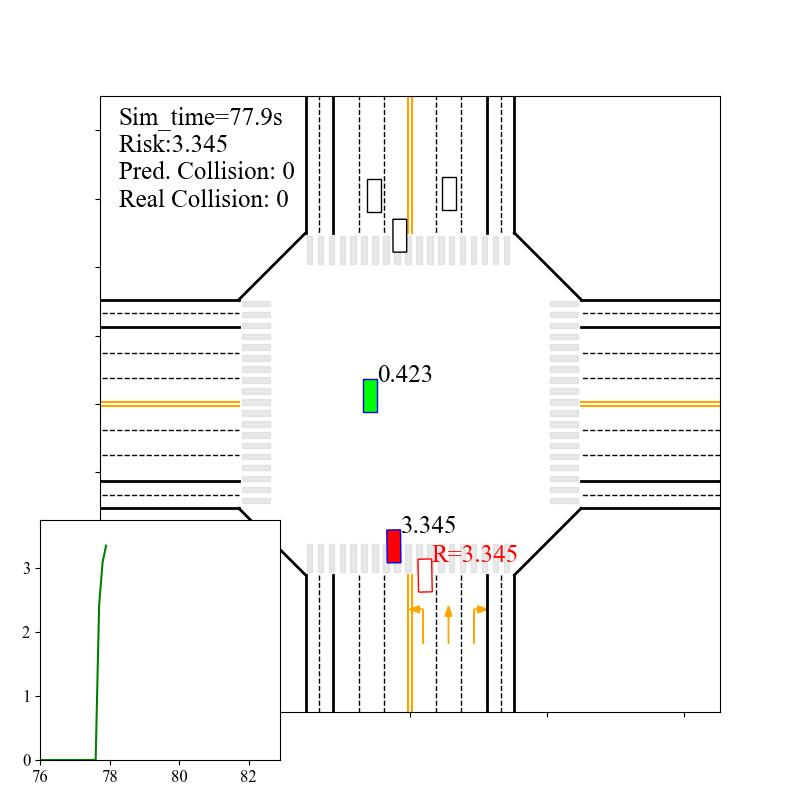

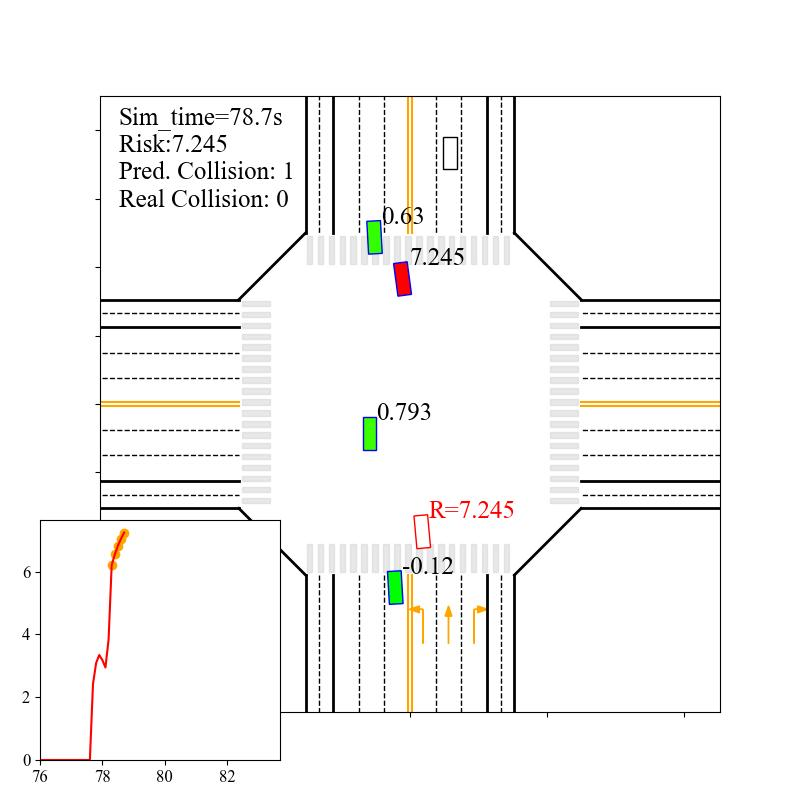

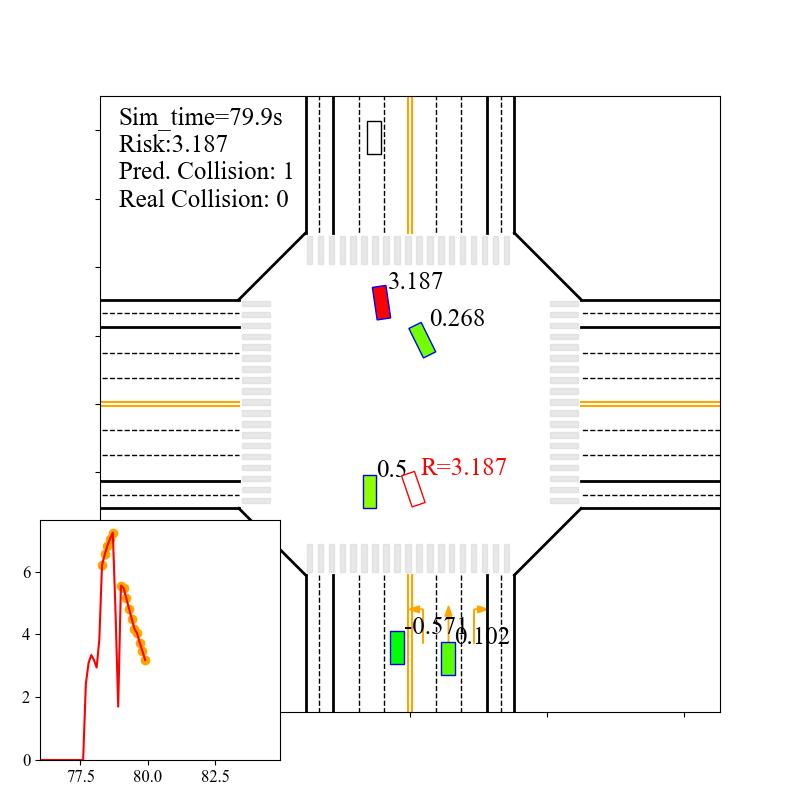

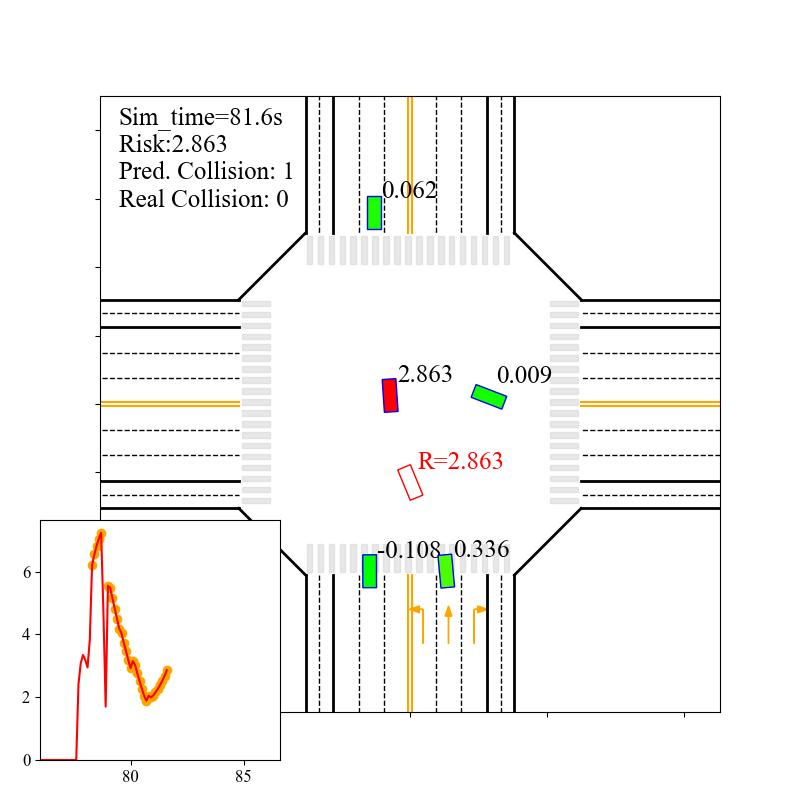

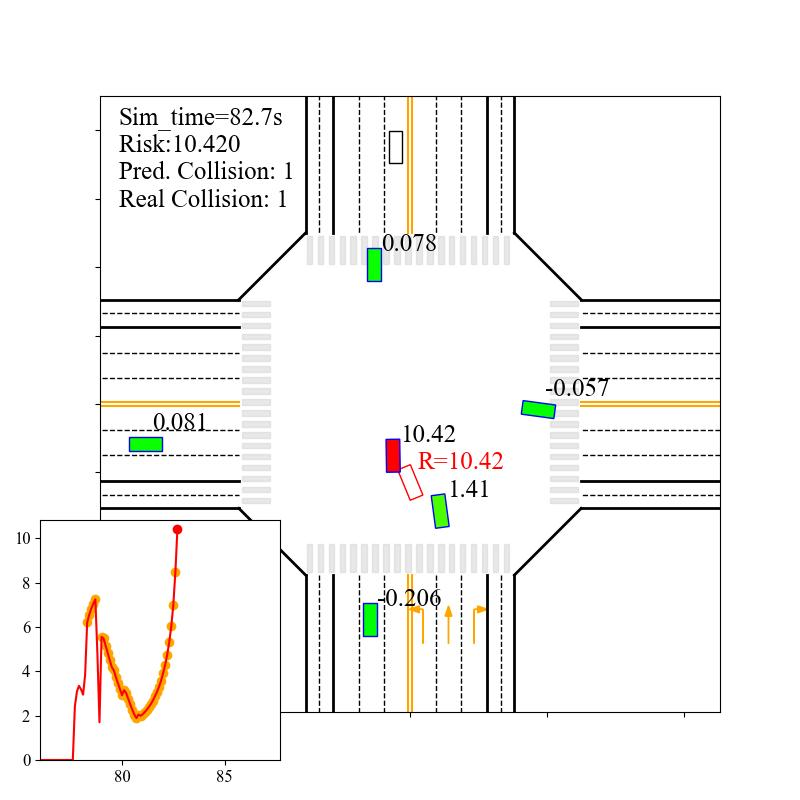

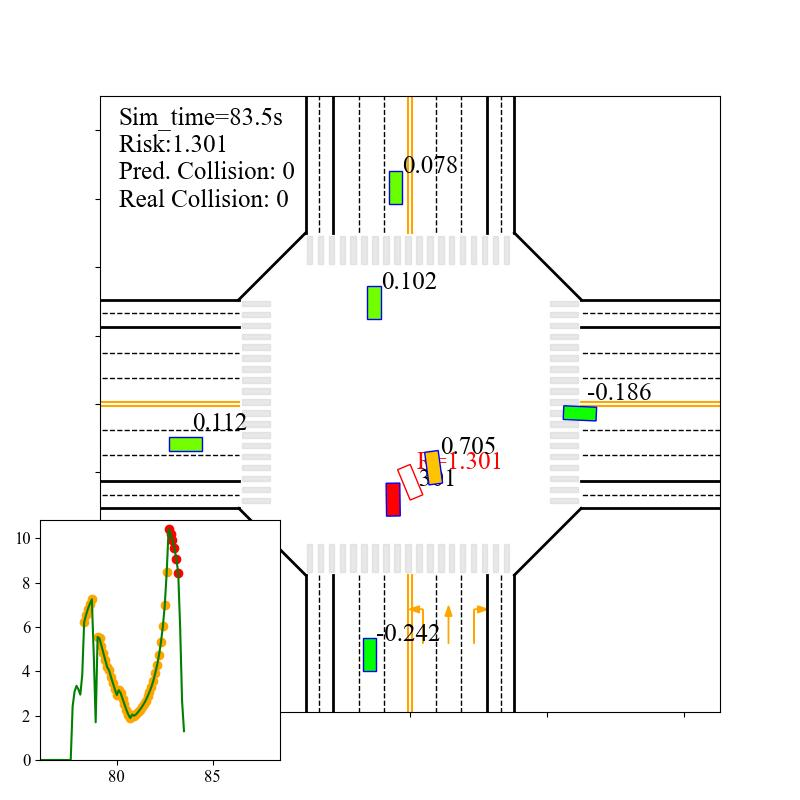

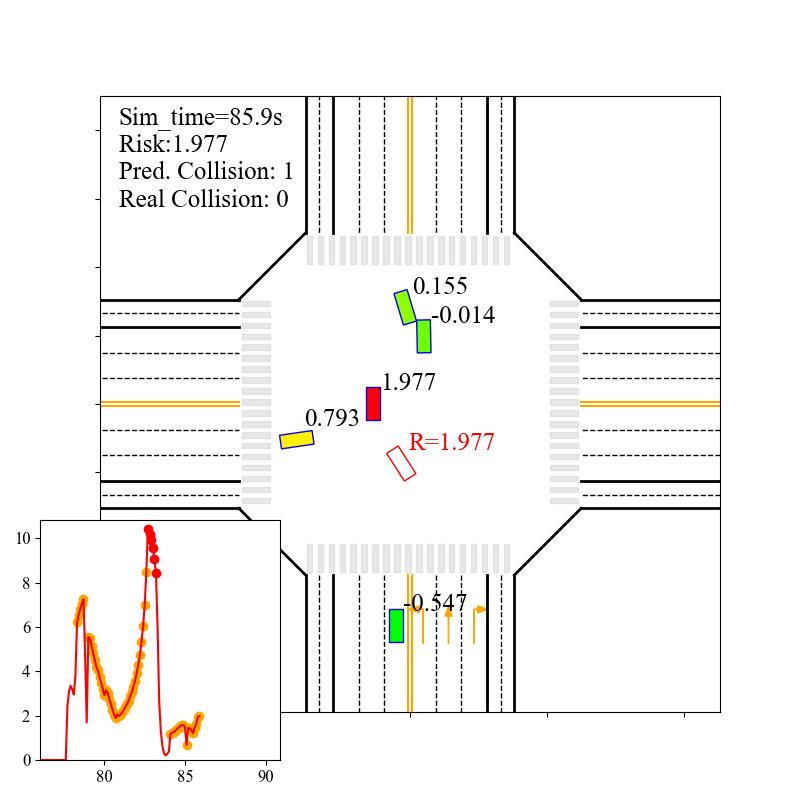

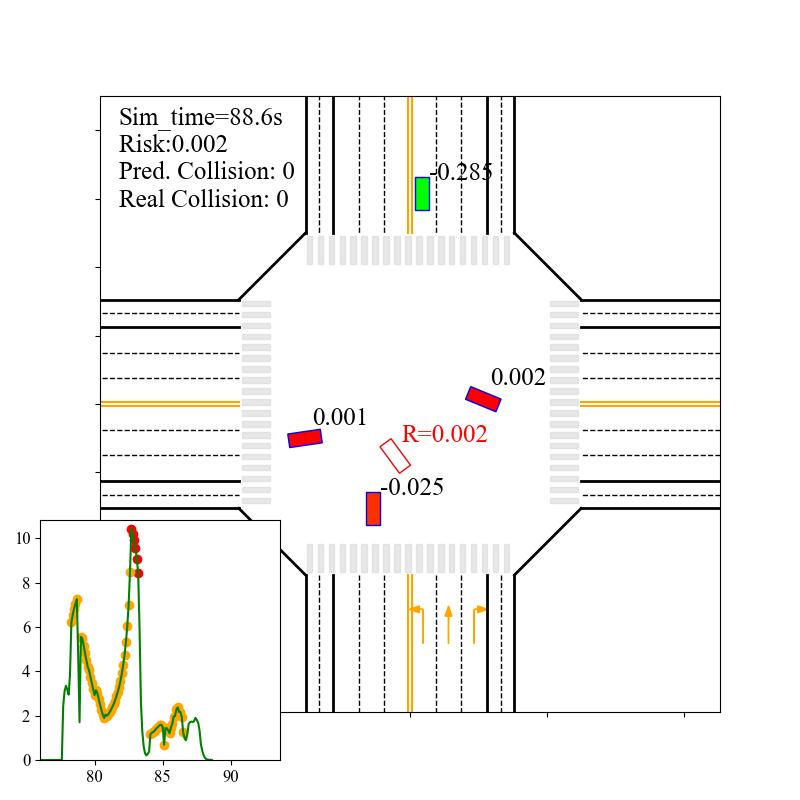

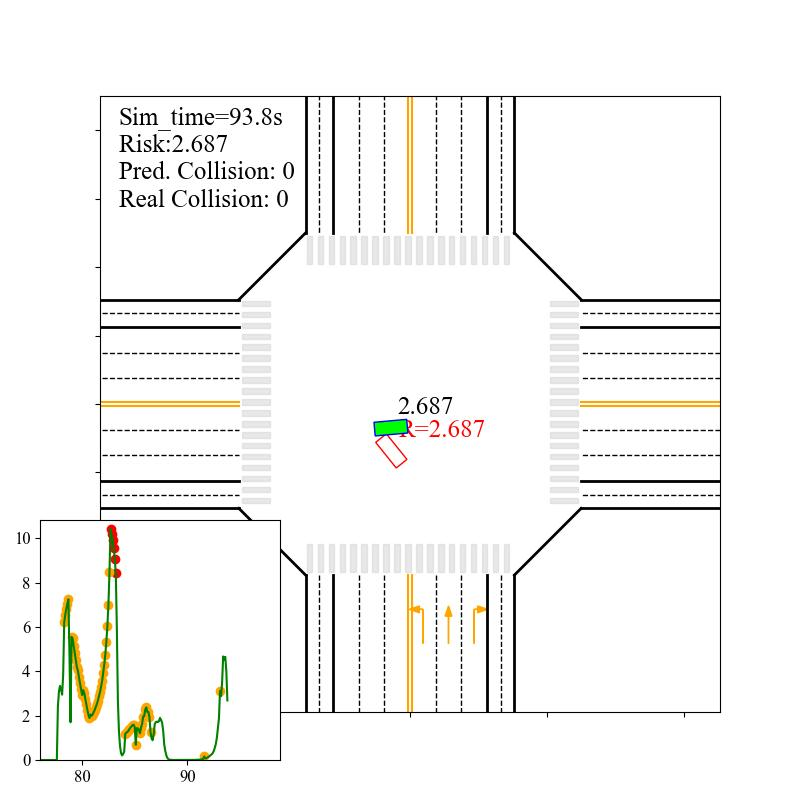

In [3]:
from PIL import Image
for i in [77.9, 78.7, 79.9, 81.6, 82.7, 83.5, 85.9, 88.6, 93.8]:
    display(Image.open("dyn_pics/{}.jpg".format(i)))